# PINN Introduction

In [ ]:
# Run this cell is you are using Google Colab
!git clone https://github.com/CPSHub/LecturePhysicsAwareML.git
%cd LecturePhysicsAwareML/PINNs
%pip install -e .

In [1]:
# Run this cell, if you are working locally
%cd ..
%pip install -e .

/Users/jaosch/projects/LecturePhysicsAwareML/PINNs
Obtaining file:///Users/jaosch/projects/LecturePhysicsAwareML/PINNs
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for pinns (pyproject.toml) ... done
  Created wheel for pinns: filename=pinns-25.2-0.editable-py3-none-any.whl size=1448 sha256=1bfb2ecb6ddcfef9e52540de2d9c12d17203649541ca79247ceb599f68254942
  Stored in directory: /private/var/folders/26/rbqx96js0w9gh1_20qpttvhr0000gn/T/pip-ephem-wheel-cache-0rro2gde/wheels/3e/11/69/742392a6c824bcfbb0ae8c43d34fff9d88de24f25f98e19c72
Successfully built pinns
  Attempting uninstall: pinns
    Found existing installation: pinns 25.2
    Uninstalling pinns-25.2:
      Successfully uninstalled pinns-25.2

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

### Define boundary conditions.

In [1]:
import jax.numpy as jnp
from pinns.lebb import Config, get_data_decorator


@get_data_decorator
def get_data(config: Config):
    if config.bc_case == 0:
        w_bc_coords = jnp.array([0.])
        w_bc_values = jnp.array([0.])
        w_x_bc_coords = jnp.array([0.])
        w_x_bc_values = jnp.array([0.])
        M_bc_coords = jnp.array([config.L])
        M_bc_values = jnp.array([0.])
        Q_bc_coords = jnp.array([config.L])
        Q_bc_values = jnp.array([config.F])
    elif config.bc_case == 1:
        # Start of task scope
        ######################
        pass # remove this for testing
        # w_bc_coords = 
        # w_bc_values = 
        # w_x_bc_coords = 
        # w_x_bc_values = 
        # M_bc_coords = 
        # M_bc_values = 
        # Q_bc_coords = 
        # Q_bc_values = 
        ######################
        # End of task scope
    else:
        NotImplementedError("Data generation is not implemented for these boundary conditions.")

    bc = {
        "w_bc_coords": w_bc_coords,
        "w_bc_values": w_bc_values,
        "w_x_bc_coords": w_x_bc_coords,
        "w_x_bc_values": w_x_bc_values,
        "M_bc_coords": M_bc_coords,
        "M_bc_values": M_bc_values,
        "Q_bc_coords": Q_bc_coords,
        "Q_bc_values": Q_bc_values
    }
    return bc


### Configure beam properties.

In [2]:
from pinns.lebb import get_config_decorator
from typing import Tuple


@get_config_decorator
def get_config(bc_case: int) -> Tuple[float, float, float, float]:
    if bc_case == 0:
        EI = 1e6
        L = 1.0
        F = 1.0
        q = 0.0
    elif bc_case == 1:
        EI = 1e6
        L = 1.0
        F = 0.0 # Unused dummy
        q = 1.0
    else:
        NotImplementedError("No configuration implemented for these boundary conditions.")

    return EI, L, F, q

### Data generation, model creation & training

In [3]:
import jax
from pinns.lebb import PINN
from pinns import train


config = get_config(bc_case=0, non_dim=True)
x, y, bc, EI, L, q = get_data(config)
weights={
    "w_bc": 1.0,
    "w_x_bc": 1.0,
    "M_bc": 1.0,
    "Q_bc": 1.0,
    "rw": 1.0
},

key = jax.random.PRNGKey(1234)
model = PINN(EI, L, q, bc, key=key)

model = train(
    model,
    x,
    weights,
    steps=50_000
)

TypeError: Config.__init__() missing 1 required positional argument: 'weights'

### Model evaluation


Evaluation:
-----------
  MSE w:     1.3290041067648417e-07
  MSE w':    3.142841009662334e-08
  MSE M:     3.6956975257851354e-09
  MSE Q:     1.98377293259e-07
  MSE w'''': 2.2742112832929706e-06


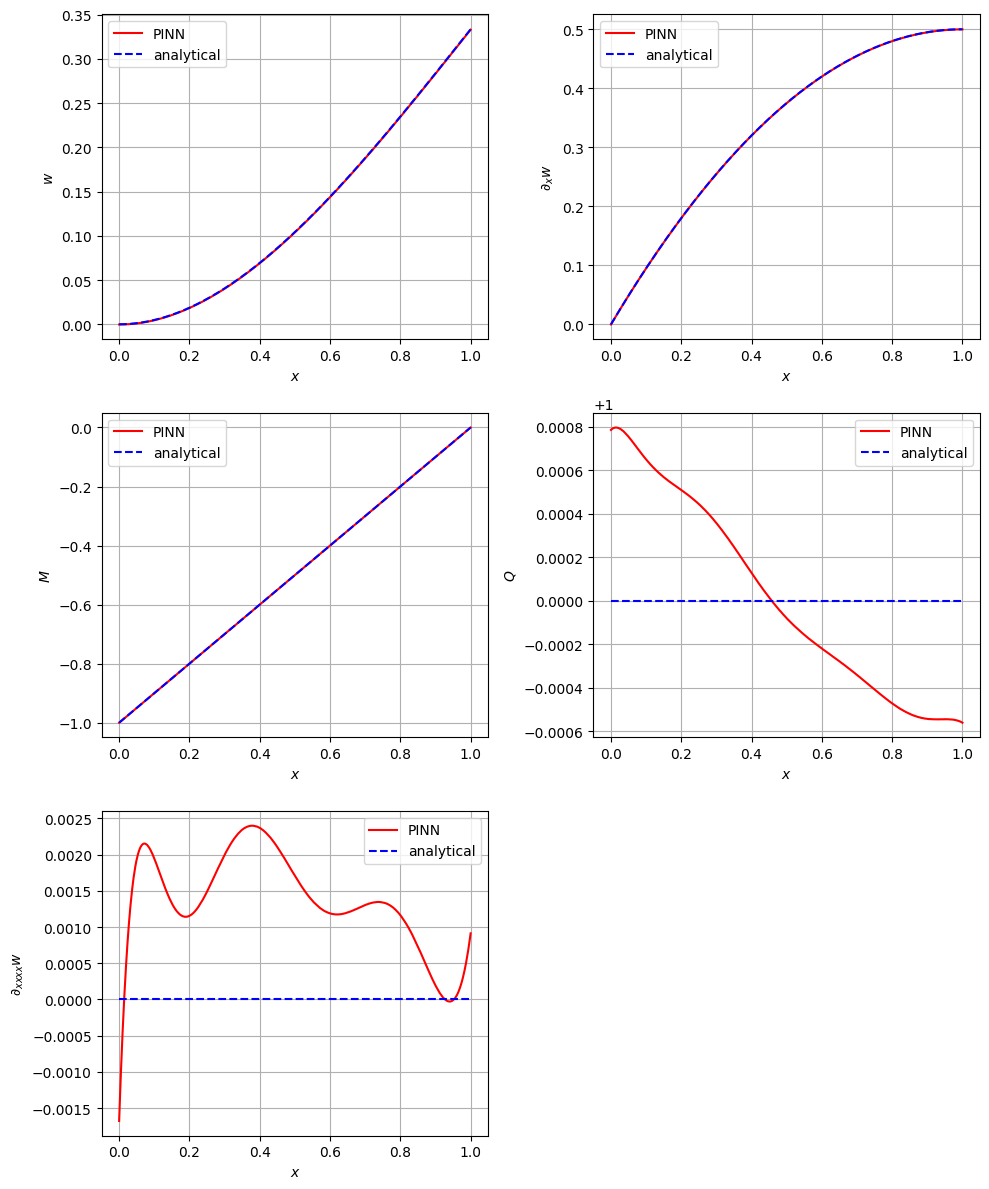

In [5]:
from pinns.lebb import evaluate


evaluate(model, x, y)

### Tasks

#### Task 1: Dedimensionalization

For `bc_case=0`, ...

a) Set `EI=1e6`, and non_dim=False`. Can the model approximate the solution?

b) Now set the `EI = 1.0`. Can the model approximate the solution now?

c) Set `EI=1e6` again and set `non_dim=True`. The model should now be able approximate the solution very well. Why does it work better than a)?  

#### Task 2: Boundary conditions

Fix the boundary conditions for `bc_case=1` withing `get_data()`. Next, calibrate the PINN and test your implementation against the analytical solution. Note, boundary conditions can be set equal to `None`to be ignored.

*Solution:*

In [ ]:
import jax.numpy as jnp

from pinns.lebb import Config, get_data_decorator


@get_data_decorator
def get_data(config: Config):
    if config.bc_case == 1:
        w_bc_coords = jnp.array([0., config.L])
        w_bc_values = jnp.array([0., 0.])
        w_x_bc_coords = None
        w_x_bc_values = None
        M_bc_coords = jnp.array([0., config.L])
        M_bc_values = jnp.array([0., 0.])
        Q_bc_coords = None
        Q_bc_values = None
    else:
        NotImplementedError("Data generation is not implemented for these boundary conditions.")

    bc = {
        "w_bc_coords": w_bc_coords,
        "w_bc_values": w_bc_values,
        "w_x_bc_coords": w_x_bc_coords,
        "w_x_bc_values": w_x_bc_values,
        "M_bc_coords": M_bc_coords,
        "M_bc_values": M_bc_values,
        "Q_bc_coords": Q_bc_coords,
        "Q_bc_values": Q_bc_values
    }
    return bc